# Exploratory Data Analysis

In [63]:
#import necessary liabries for data exploration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

import itertools
import math
import time
import pickle

import statsmodels.api as sm
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from scipy import stats
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures 
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

I will be bringing in one of the functions I used for one of my projects, it is going to be useful throughout the training process to evaluate the model. 

In [40]:
#Function to assist with evaluating the models
def evaluate (estimator, X_train,y_train, X_val, y_val):
    """
    Evaluate the amount of error between the model's predictions 
    and actiual values for both train and test set
    
    Parameters:
    y_train - array like, actual values for 'price' 
    train_preds - array like predicted values for 'price'
    y_val/test -array like actual values for 'price'
    val_preds/test - array like predicted values for 'price'
    returns:
    None
    """
    
   #predict the target on the training and validation data
    train_preds = estimator.predict(X_train)
    val_preds = estimator.predict(X_val)
    
    print("Scores")
    
    print(f"Train score: {train_preds}") #training score
    print(f"validation score: {val_preds}") #validation/Test score
    
    print("Rsquared:")

    print(f"Train R2: {r2_score(y_train,train_preds):.4f}") #rsquare metrics for train
    print(f"Validation R2: {r2_score(y_val,val_preds):.4f}") #rsquare metrics for val/test

    print("-----")

    print("Root Mean squared Error:")

    print(f"Train RMSE: {mean_squared_error(y_train,train_preds,squared = False):.2f}") #rmse metrics for train
    print(f"Validation RMSE: {mean_squared_error(y_val,val_preds, squared = False):.2f}") #rmse metrics for val/test

    print("-----")

    print(" Mean absolute Error:")

    print(f"Train MAE: {mean_absolute_error(y_train,train_preds):.2f}") #MAE metrics for train
    print(f"Validation MAE: {mean_absolute_error(y_val,val_preds):.2f}") #MAE metrics for val/test
    
    #calculate the residual
    train_residual = y_train - train_preds #residual for train
    val_residual = y_val - val_preds #residual for val / test
    
    #QQplot to check the normality of our 
    sm.qqplot(val_residual,line ='45',fit =True) 

Data has already been split so I will only be working with the train dataset.

In [2]:
#read the train data
train_data = pd.read_csv("../Data/train.csv")
test_data = pd.read_csv("../Data/test.csv")

In [3]:
#view the first ten rows of the data
train_data.head(10)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4
5,1,State_1,Commercial,Warehouse_Selfstorage,119900.0,1956.0,NaN,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,6.597715,5
6,1,State_1,Commercial,Warehouse_Nonrefrigerated,91367.0,1982.0,56.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,12.817841,6
7,1,State_1,Commercial,Warehouse_Nonrefrigerated,50422.0,1947.0,99.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,22.392014,7
8,1,State_1,Commercial,Office_Uncategorized,122020.0,1929.0,98.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,28.199578,8
9,1,State_1,Commercial,Office_Uncategorized,102612.0,1979.0,83.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,29.515952,9


In [4]:
#view the last ten rows of the data
train_data.tail(10)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
75747,6,State_11,Commercial,Grocery_store_or_food_market,58480.0,1980.0,37.0,63.1,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,188.519318,75747
75748,6,State_11,Commercial,Commercial_Other,22800.0,1994.0,NaN,63.1,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,97.194772,75748
75749,6,State_11,Commercial,Commercial_Other,47237.0,1948.0,NaN,63.1,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,126.285151,75749
75750,6,State_11,Commercial,Commercial_Other,72000.0,2013.0,NaN,63.1,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,40.525884,75750
75751,6,State_11,Residential,2to4_Unit_Building,28284.0,1928.0,79.0,63.1,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,70.298783,75751
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,132.918411,75752
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,...,25,3,0,0,NaN,NaN,NaN,NaN,39.483672,75753
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,...,6,0,0,0,NaN,NaN,NaN,NaN,48.404398,75754
75755,6,State_11,Commercial,Commercial_Other,53575.0,2012.0,NaN,36.6,26,36.612903,...,6,0,0,0,NaN,NaN,NaN,NaN,592.022750,75755
75756,6,State_11,Residential,2to4_Unit_Building,23888.0,1974.0,51.0,36.6,27,36.935484,...,16,0,0,0,NaN,NaN,NaN,NaN,29.154684,75756


In [5]:
#check the data info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

Looking at the above information, we can see here that we are missing some data.

In [6]:
#let's view the shape of the data
train_data.shape

(75757, 64)

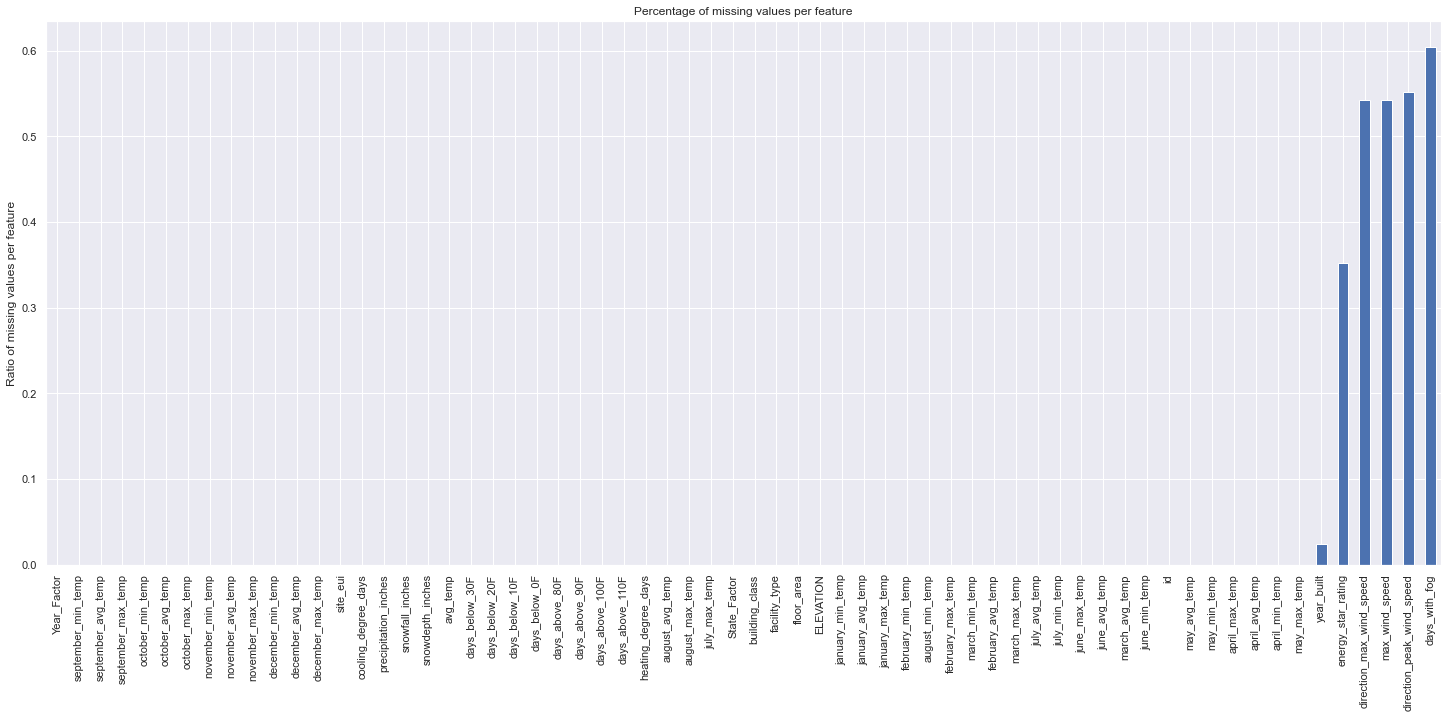

In [7]:
#view the missing values per features in percentage
train_data.isna().mean().sort_values().plot(
    kind="bar", figsize=(25, 10),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");

There are 55.2% missing values in direction_peak_wind_speed columns that are missing, 54.23% values in max_wind_speed and direction_max_wind_speed. Also 60.1% missing values from the days_with_fog columns. Those features have more than 50% missing values. So let's go ahead and drop any features with more than 15% missing values. 

In [8]:
train_data = train_data.dropna(thresh = train_data.shape[0] *0.85, axis=1)
train_data.shape

(75757, 59)

In [9]:
#check if there is duplicated values
train_data.duplicated().sum()

0

In [10]:
train_data.isnull().sum().sum()

1837

After dropping all the columns with more than 15% missing values, we only have year built with 1,837 missing values. Let's go ahead and fill the missing values with zeros.

In [11]:
#fill all the nan values with zero
#check if there is still null values in the dataset
train_data = train_data.fillna(0, axis =1)
train_data.isnull().sum().sum()

0

In [12]:
#view the statistical summary of the data
train_data.describe()

,Year_Factor,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,...,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui,id
count,75757.000000,7.575700e+04,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,...,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000
mean,4.367755,1.659839e+05,1904.966089,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,58.486278,...,48.756511,17.447932,4.886532,0.876764,82.709809,14.058701,0.279539,0.002442,82.584693,37878.000000
std,1.471441,2.468758e+05,302.528096,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,8.414611,...,27.587124,14.469435,7.071221,2.894244,25.282913,10.943996,2.252323,0.142140,58.255403,21869.306509
min,1.000000,9.430000e+02,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,38.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.001169,0.000000
25%,3.000000,6.237900e+04,1926.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,55.000000,...,22.000000,5.000000,0.000000,0.000000,72.000000,6.000000,0.000000,0.000000,54.528601,18939.000000
50%,5.000000,9.136700e+04,1950.000000,25.000000,11.000000,34.451613,59.000000,9.000000,34.107143,61.000000,...,50.000000,11.000000,2.000000,0.000000,84.000000,12.000000,0.000000,0.000000,75.293716,37878.000000
75%,6.000000,1.660000e+05,1976.000000,42.700000,13.000000,37.322581,62.000000,20.000000,40.879310,62.000000,...,66.000000,26.000000,7.000000,0.000000,97.000000,17.000000,0.000000,0.000000,97.277534,56817.000000
max,6.000000,6.385382e+06,2015.000000,1924.500000,49.000000,64.758065,91.000000,48.000000,65.107143,89.000000,...,170.000000,93.000000,59.000000,31.000000,260.000000,185.000000,119.000000,16.000000,997.866120,75756.000000


In [13]:
#let's view the columns
train_data.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'ELEVATION', 'january_min_temp',
       'january_avg_temp', 'january_max_temp', 'february_min_temp',
       'february_avg_temp', 'february_max_temp', 'march_min_temp',
       'march_avg_temp', 'march_max_temp', 'april_min_temp', 'april_avg_temp',
       'april_max_temp', 'may_min_temp', 'may_avg_temp', 'may_max_temp',
       'june_min_temp', 'june_avg_temp', 'june_max_temp', 'july_min_temp',
       'july_avg_temp', 'july_max_temp', 'august_min_temp', 'august_avg_temp',
       'august_max_temp', 'september_min_temp', 'september_avg_temp',
       'september_max_temp', 'october_min_temp', 'october_avg_temp',
       'october_max_temp', 'november_min_temp', 'november_avg_temp',
       'november_max_temp', 'december_min_temp', 'december_avg_temp',
       'december_max_temp', 'cooling_degree_days', 'heating_degree_days',
       'precipitation_inches', 'snowfall_inches', 'snowdepth_inche

In [14]:
#checking for columns with unique value
train_data[[col for col in train_data.columns if train_data[col].dtype == 'object']].describe()

,State_Factor,building_class,facility_type
count,75757,75757,75757
unique,7,2,60
top,State_6,Residential,Multifamily_Uncategorized
freq,50840,43558,39455


In [15]:
#view the target
train_data['site_eui']

0        248.682615
1         26.500150
2         24.693619
3         48.406926
4          3.899395
            ...    
75752    132.918411
75753     39.483672
75754     48.404398
75755    592.022750
75756     29.154684
Name: site_eui, Length: 75757, dtype: float64

In [16]:
#let us drop the columns we will not be including in the dataset, then view it. 
train_data=train_data.drop(['id'],axis=1)
train_data.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,2.4,36,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,1.8,36,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,1.8,36,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,1.8,36,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,2.4,36,50.5,68,...,56.972603,0,0,0,0,14,0,0,0,3.899395


In [17]:
train_data['site_eui'].describe()

count    75757.000000
mean        82.584693
std         58.255403
min          1.001169
25%         54.528601
50%         75.293716
75%         97.277534
max        997.866120
Name: site_eui, dtype: float64

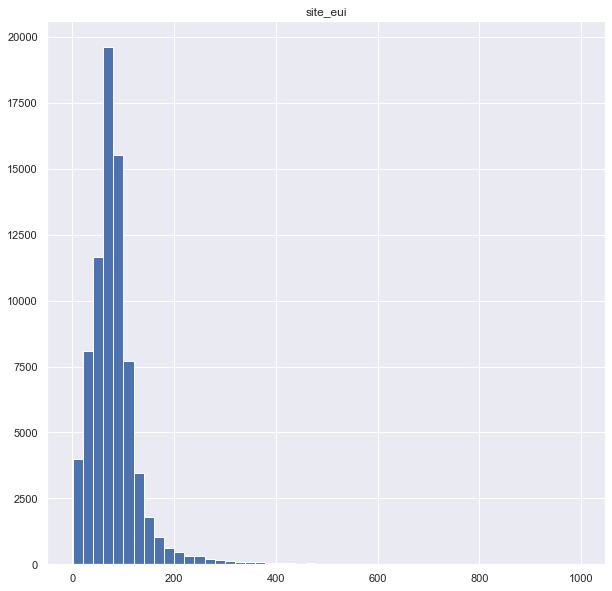

In [18]:
train_data.hist(column='site_eui', bins = 50, figsize=(10,10))
plt.show()

As you can see that the target is positively skewed to the right showing that there are outliers. Let's go ahead and check the boundary values.

In [19]:
#check the boundary values
print("Highest allowed",train_data['site_eui'].mean() + 3 *train_data['site_eui'].std())
print("Lowest allowed",train_data['site_eui'].mean() - 3 *train_data['site_eui'].std())

Highest allowed 257.35090061384864
Lowest allowed -92.18151534140623


Now let's find the outliers

In [20]:
#check for outliers
outliers = train_data[(train_data['site_eui'] > 257.35) | (train_data['site_eui'] > -92.18)]
outliers

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,2.4,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,2.4,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,3.899395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,36.6,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,132.918411
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,36.6,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,39.483672
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,36.6,26,36.612903,48,...,47.911202,26,2,0,0,6,0,0,0,48.404398
75755,6,State_11,Commercial,Commercial_Other,53575.0,2012.0,36.6,26,36.612903,48,...,47.911202,26,2,0,0,6,0,0,0,592.022750


Now let's trim off the outliers, cap on it and then apply the capping.

In [21]:
#trimming off the outliers
train_data =train_data[(train_data['site_eui'] < 257.35)&(train_data['site_eui'] > -92.18)]
train_data

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,2.4,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,2.4,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,3.899395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75751,6,State_11,Residential,2to4_Unit_Building,28284.0,1928.0,63.1,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,70.298783
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,36.6,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,132.918411
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,36.6,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,39.483672
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,36.6,26,36.612903,48,...,47.911202,26,2,0,0,6,0,0,0,48.404398


In [22]:
#Capping on outliers
upper_limit = train_data['site_eui'].mean() + 3 *train_data['site_eui'].std()
lower_limit = train_data['site_eui'].mean() - 3 *train_data['site_eui'].std()

In [23]:
#Now let's apply the Capping
train_data['site_eui'] = np.where(train_data['site_eui'] > upper_limit,
                               upper_limit,np.where(train_data['site_eui'] < lower_limit,
                                                    lower_limit,train_data['site_eui']))

In [24]:
train_data =train_data.reset_index(drop=True)
train_data

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,2.4,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,194.640593
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,1.8,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,2.4,36,50.500000,68,...,56.972603,0,0,0,0,14,0,0,0,3.899395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74536,6,State_11,Residential,2to4_Unit_Building,28284.0,1928.0,63.1,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,70.298783
74537,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,36.6,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,132.918411
74538,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,36.6,28,43.451613,56,...,55.147541,6,0,0,0,25,3,0,0,39.483672
74539,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,36.6,26,36.612903,48,...,47.911202,26,2,0,0,6,0,0,0,48.404398


In [25]:
#view the summary statistics of the target
train_data['site_eui'].describe()

count    74541.000000
mean        77.158390
std         37.446755
min          1.001169
25%         54.086698
50%         74.695355
75%         95.853973
max        194.640593
Name: site_eui, dtype: float64

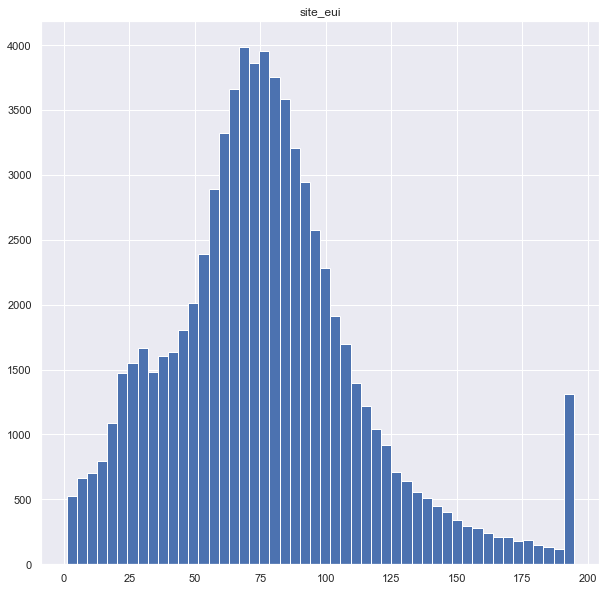

In [26]:
#Now let's plot the histogram again to see if the outlier has been removed.
train_data.hist(column='site_eui', bins = 50, figsize=(10,10))
plt.show()

After Capping the outliers now if you look at the histogram, you will see that the target has been normalize. All outliers has been removed which give us similar data across all the data.

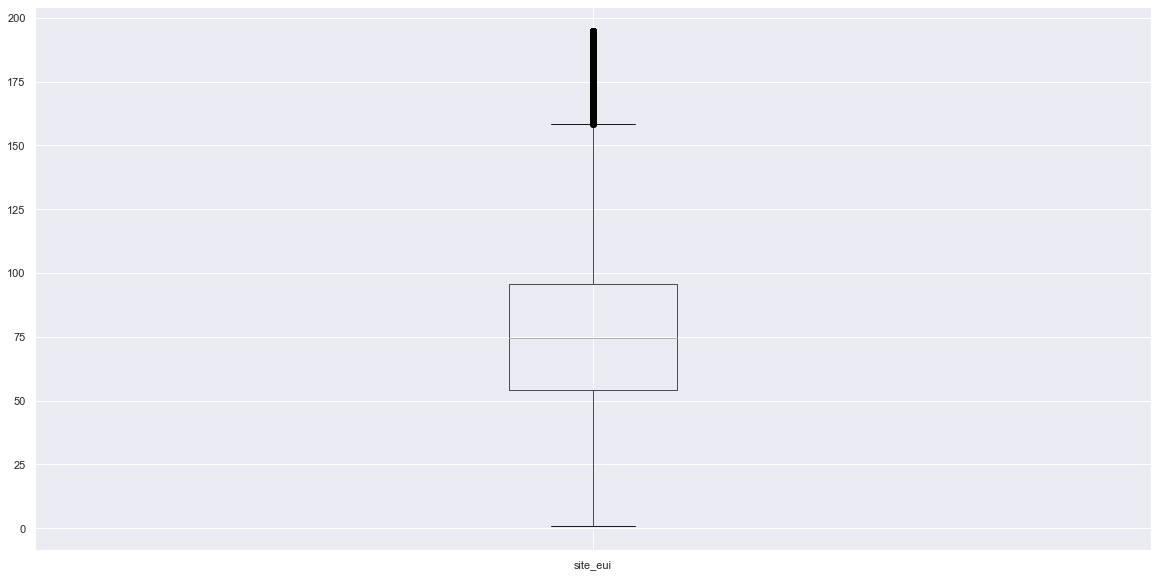

In [27]:
#plot boxplot to view outlier
plt.figure(figsize = (20,10))
train_data.boxplot(column = 'site_eui')
plt.show()

Text(0.5, 1.0, 'MultiCollinearity Btw target and Features ')

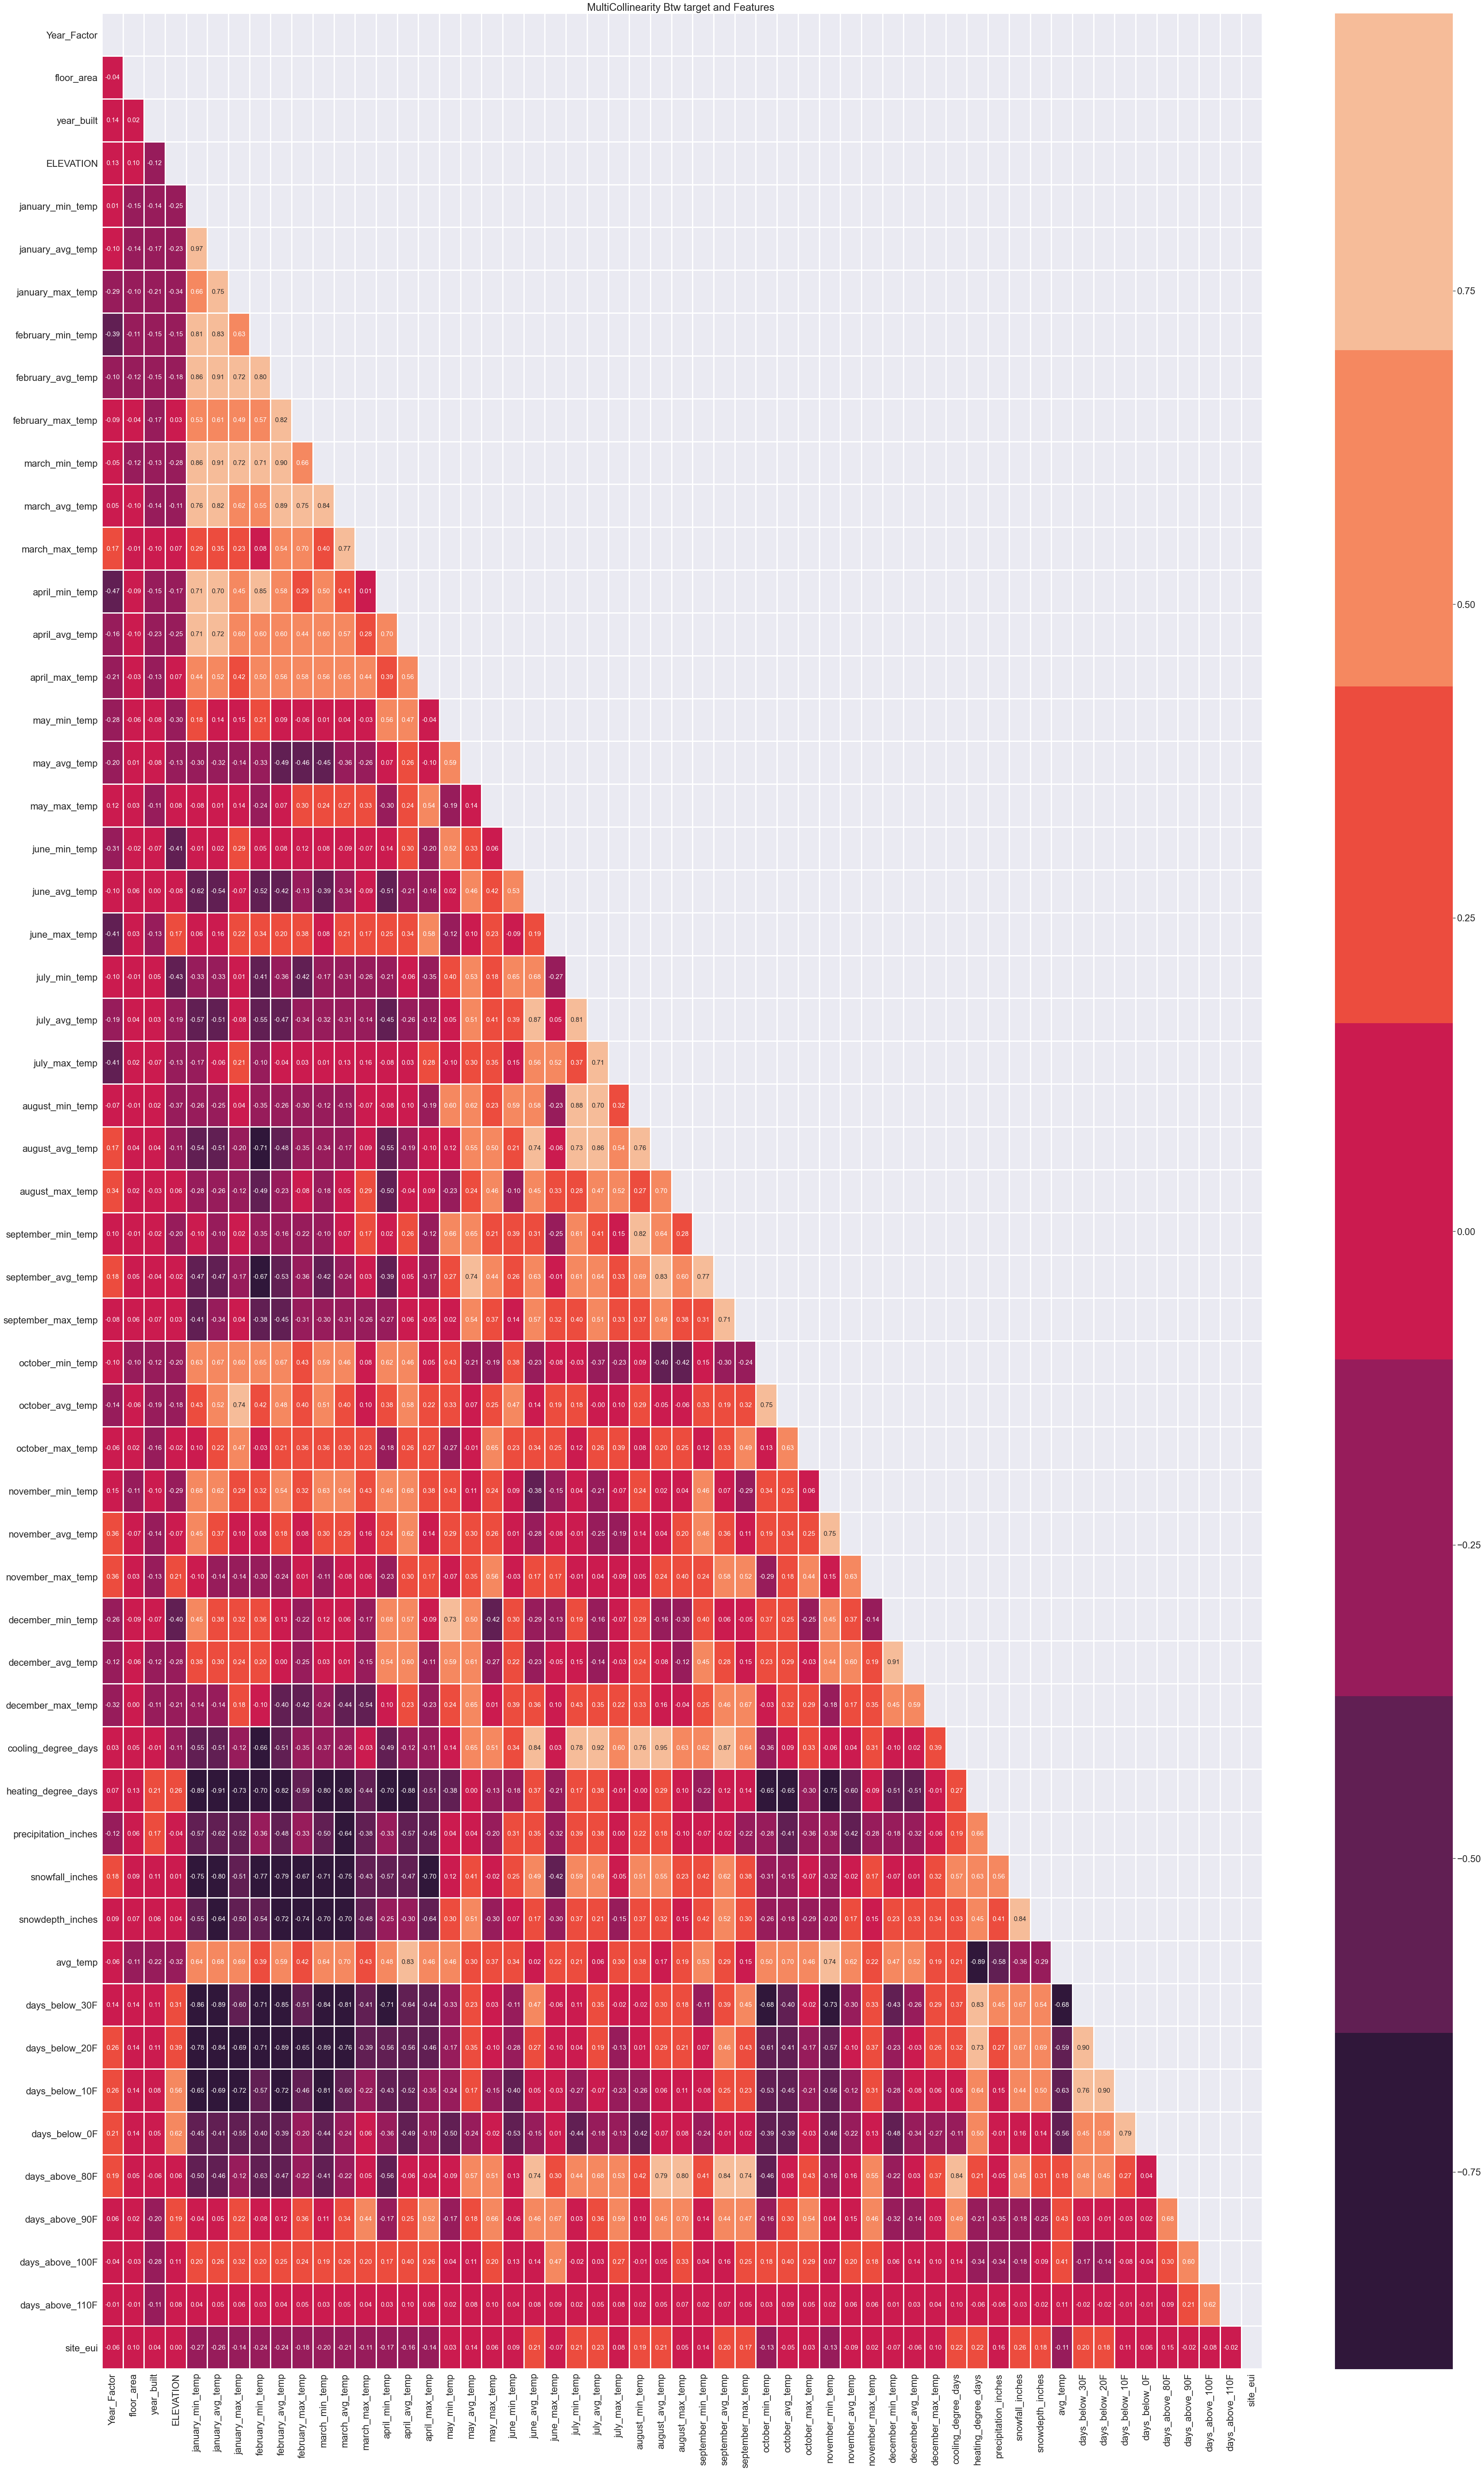

In [28]:
#let's visualize the multicolinearity among the features.
sns.set(font_scale =2)
plt.figure(figsize = (60,100))
ax = sns.heatmap(train_data.corr(),mask =np.triu(np.ones_like(train_data.corr(),dtype = bool)), 
            annot = True,cmap =sns.color_palette('rocket',7),
            linewidths=2,linecolor='white',fmt='.2f',annot_kws={"size":15})
plt.title("MultiCollinearity Btw target and Features ")

Text(0.5, 1.0, 'Correlation between the target and features')

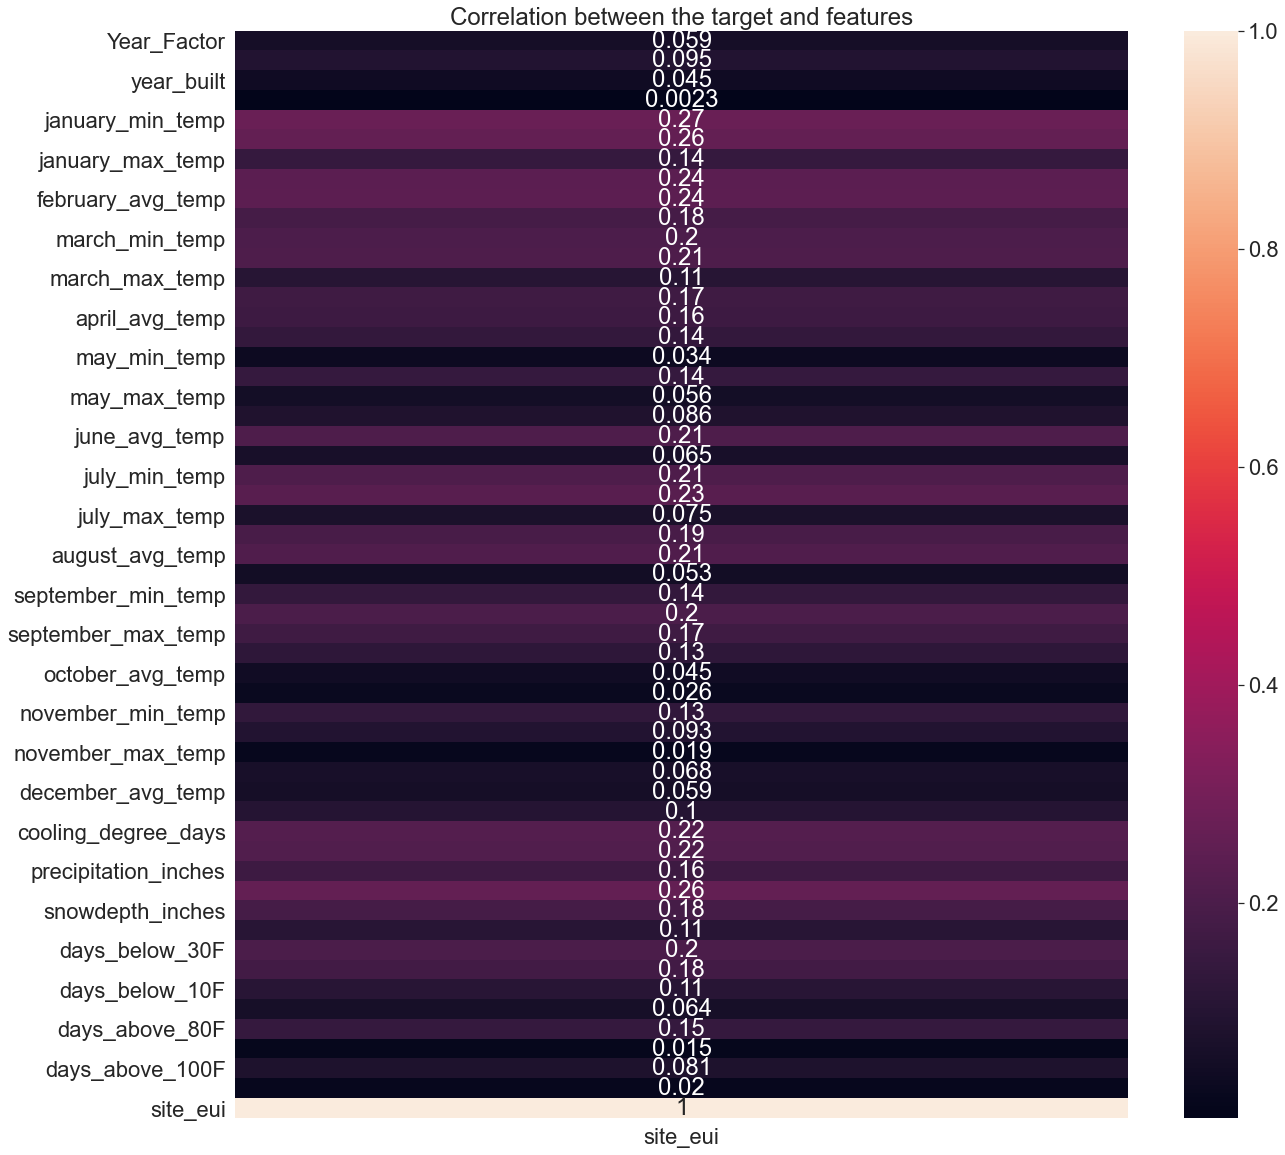

In [29]:
#Using the heatmap to view the feature that correlate with the target.
plt.figure(figsize = (20,20))
ax =sns.heatmap(abs(train_data.corr())[['site_eui']], annot = True);
plt.title("Correlation between the target and features")

Looking at the graph above you can see that there is a high multi-collinearity between the energy star rating and the site energy usage.Also we will be dropping the State_Factor, building_class and facility_type because there is no correlation between the target and those features.

In [30]:
# #let us drop the columns we will not be including in the dataset, then view it. 
# train_data=train_data.drop(['State_Factor','facility_type','ELEVATION'],axis=1)
# train_data.head()

Now let us go ahead and split our data into dependent and independent variables

In [31]:
#define X and y
X = train_data.drop('site_eui',axis=1)
y= train_data['site_eui']

In [32]:
#view the shape of the data
X.shape, y.shape

((74541, 57), (74541,))

In [33]:
#View the first ten rows of the dependent features
X.head(10)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,2.4,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,1.8,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,1.8,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,1.8,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,2.4,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
5,1,State_1,Commercial,Warehouse_Selfstorage,119900.0,1956.0,2.4,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
6,1,State_1,Commercial,Warehouse_Nonrefrigerated,91367.0,1982.0,2.4,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
7,1,State_1,Commercial,Warehouse_Nonrefrigerated,50422.0,1947.0,2.4,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
8,1,State_1,Commercial,Office_Uncategorized,122020.0,1929.0,2.4,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0
9,1,State_1,Commercial,Office_Uncategorized,102612.0,1979.0,2.4,36,50.5,68,...,0,56.972603,0,0,0,0,14,0,0,0


In [34]:
#view the first ten rows of the target 
y.head(10)

0    194.640593
1     26.500150
2     24.693619
3     48.406926
4      3.899395
5      6.597715
6     12.817841
7     22.392014
8     28.199578
9     29.515952
Name: site_eui, dtype: float64

In [35]:
#let's view the unique values and classify them into it's unique categories
num_cols = []
ohe_cols = []
freq_cols =[]

for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        num_cols.append(col)
    elif X[col].nunique() < 10:
        ohe_cols.append(col)
    else:
        freq_cols.append(col)

In [36]:
#print the list of numerical columns,categorical columns and frequency columns
print(f"list of numerical columns: {num_cols}")
print("--")
print(f"list of categorical columns:{ohe_cols}")
print("--")
print(f"list of Frequency columns:{freq_cols}")

list of numerical columns: ['Year_Factor', 'floor_area', 'year_built', 'ELEVATION', 'january_min_temp', 'january_avg_temp', 'january_max_temp', 'february_min_temp', 'february_avg_temp', 'february_max_temp', 'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp', 'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp', 'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp', 'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp', 'august_avg_temp', 'august_max_temp', 'september_min_temp', 'september_avg_temp', 'september_max_temp', 'october_min_temp', 'october_avg_temp', 'october_max_temp', 'november_min_temp', 'november_avg_temp', 'november_max_temp', 'december_min_temp', 'december_avg_temp', 'december_max_temp', 'cooling_degree_days', 'heating_degree_days', 'precipitation_inches', 'snowfall_inches', 'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F', 'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F'

It seems here that we do not have any categorical variables. Now we can go ahead split the data,and scale it so that we can have equal data among the records.

In [37]:
#split the data into training and validation data. 
#we will be using the validation data to train the algorithms
#then use the test data on the final model.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# create another train data and validation data from the split
train_df = pd.concat([X_train,y_train], axis= 1)
validation_df = pd.concat([X_val,y_val], axis =1)

train_df.shape , validation_df.shape

((55905, 58), (18636, 58))

In [38]:
# set up pipeline for preprocessing 
# for numeric columns, we need to scale it
# for unique value <3 columns, we need to one hot encode it
# for unique value >3 columns, we need to frequency encode it
ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value = 0)),
    ('oh_encoder', OneHotEncoder(handle_unknown='ignore'))
])

freq_transformer = Pipeline(steps=[
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)),
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0))
])

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    
])

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols),
        ('scaler', num_transformer, num_cols)
    ])

preprocessor.fit(X_train)

ColumnTransformer(transformers=[('ohe',
                                 Pipeline(steps=[('ohe_imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('oh_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['State_Factor', 'building_class']),
                                ('freq',
                                 Pipeline(steps=[('freq_encoder',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               min_group_size=0.05,
                                                               normalize=True)),
                                                 ('freq_imputer',
                                                  Simple...
             

## Baseline Model

Now let's go ahead and build our baseline model so that we can use the scoring to train our data and compare across other algorithms.

In [39]:
baseline = Pipeline(steps = [('preprocessor', preprocessor),
                             ('reg', LinearRegression())])
baseline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('ohe_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('oh_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['State_Factor',
                                                   'building_class']),
                                                 ('freq',
                                                  Pipeline(steps=[('freq_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                  

Now I will go ahead and use the function to evaluate the baseline model.

Scores
Train score: [96.45068359 89.72216797 78.73291016 ... 71.36181641 62.90039062
 83.30859375]
validation score: [84.45458984 90.36230469 80.38916016 ... 83.48925781 40.72802734
 38.49414062]
Rsquared:
Train R2: 0.1224
Validation R2: 0.1214
-----
Root Mean squared Error:
Train RMSE: 35.10
Validation RMSE: 35.04
-----
 Mean absolute Error:
Train MAE: 25.57
Validation MAE: 25.48


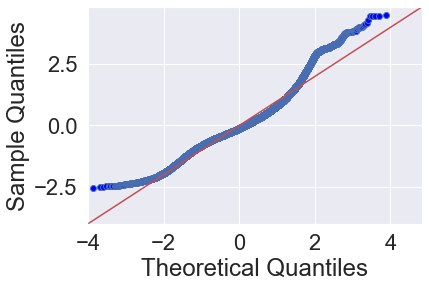

In [41]:
#evalutae the baseline model
evaluate(baseline, X_train,y_train, X_val, y_val)

As you can see the baseline model is not doing good with a R-squared score of 12%. It simply mean that the model is over-fitting compared to the number of data sample with a very high root mean square error.That said, let's go ahead and build different model and then tune them with different parameters.

# Feature Engineering with Gridsearch cv

First we will use hyper-parameter with decisionTreeRegressor algorithm.

In [56]:
#DecisionTreeRegressor
d_tree = Pipeline(steps = [('preprocessor', preprocessor),
                             ('model', DecisionTreeRegressor())])
cross_validate(d_tree,X_train,y_train,return_train_score = True, scoring='r2', cv=5)

{'fit_time': array([0.92558098, 0.90983772, 0.95820189, 0.90061212, 0.93625093]),
 'score_time': array([0.04560614, 0.04222608, 0.04159403, 0.04098487, 0.04181194]),
 'test_score': array([-0.35956661, -0.36459164, -0.22027525, -0.35228036, -0.24846826]),
 'train_score': array([0.997406  , 0.9978205 , 0.99677788, 0.99755414, 0.99745534])}

In [58]:
param = [{'model__criterion':['mse','friedman_mse'],
          'model__splitter':['best'],
          'model__max_depth': [5,10,20],
          'model__min_samples_split':[10,100],
          'model__max_features': ['sqrt']}]

grid = GridSearchCV(estimator= d_tree,
                    param_grid = param, scoring= 'r2')
result = grid.fit(X_train,y_train)

In [59]:
result.best_params_

{'model__criterion': 'mse',
 'model__max_depth': 10,
 'model__max_features': 'sqrt',
 'model__min_samples_split': 100,
 'model__splitter': 'best'}

In [60]:
result.best_score_

0.1283862828859978

Scores
Train score: [86.86089099 76.21320728 79.37331521 ... 77.26187954 65.57867208
 95.10500342]
validation score: [86.83384914 80.59516134 81.25763933 ... 82.29896055 60.56237686
 35.02799178]
Rsquared:
Train R2: 0.1488
Validation R2: 0.1331
-----
Root Mean squared Error:
Train RMSE: 34.57
Validation RMSE: 34.81
-----
 Mean absolute Error:
Train MAE: 25.04
Validation MAE: 25.10


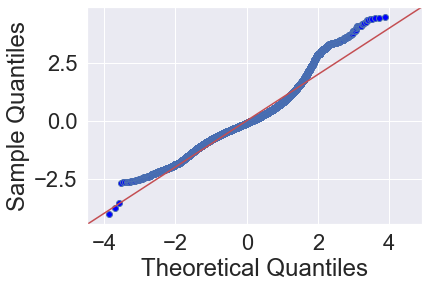

In [61]:
evaluate(result.best_estimator_,X_train,y_train, X_val, y_val)

SGDRegressor

In [72]:
#SGDRegression
reg_param = Pipeline(steps = [('preprocessor', preprocessor),
                             ('model', SGDRegressor())])

In [73]:
param = [{'model__loss':['squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'],
          'model__penalty':['l2','l1','elasticnet'],
          'model__learning_rate': ['optimal','constant'],
          'model__max_iter':[500,1000,2000]}]

grid = GridSearchCV(estimator= reg_param,
                    param_grid = param, scoring= 'r2')
result = grid.fit(X_train,y_train)

In [74]:
result.best_params_

{'model__learning_rate': 'optimal',
 'model__loss': 'epsilon_insensitive',
 'model__max_iter': 2000,
 'model__penalty': 'l1'}

In [75]:
result.best_score_

0.10533419270239844

Scores
Train score: [90.18246368 85.91934702 76.4401734  ... 68.11440227 53.41247448
 79.99104902]
validation score: [82.14495925 86.17005039 78.86209846 ... 81.33379693 33.40566854
 31.32732879]
Rsquared:
Train R2: 0.1060
Validation R2: 0.1067
-----
Root Mean squared Error:
Train RMSE: 35.43
Validation RMSE: 35.34
-----
 Mean absolute Error:
Train MAE: 25.28
Validation MAE: 25.14


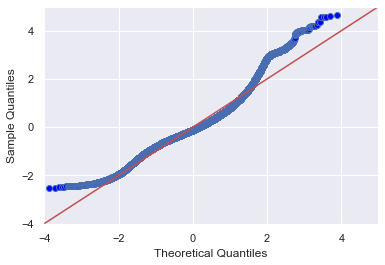

In [76]:
evaluate(result.best_estimator_,X_train,y_train, X_val, y_val)

In [49]:
# #Let's view the coefficients for all the attributes
# coef_base = pd.DataFrame(base.coef_,X.columns, columns = ['Coefficient'])
# coef_base = coef_base.sort_values(by=['Coefficient'],ascending =False)
# coef_base